## Optimización sin Restricciones:
### Rosenbrock: visualización + comparación de 3 métodos (GD, Newton, BFGS)
Reglas del entorno: usar matplotlib (sin seaborn), un gráfico por figura, sin especificar colores.
Se generarán:
1) Superficie 3D y contornos 2D de la función de Rosenbrock
2) Ejecución de: Gradiente (Armijo), Newton (Armijo), BFGS (Armijo)
3) Gráfico de convergencia f(x_k) vs iteración (misma escala de iteraciones)
4) Gráfico de trayectorias en el plano (x,y) mostrando inicio y final tras K iteraciones

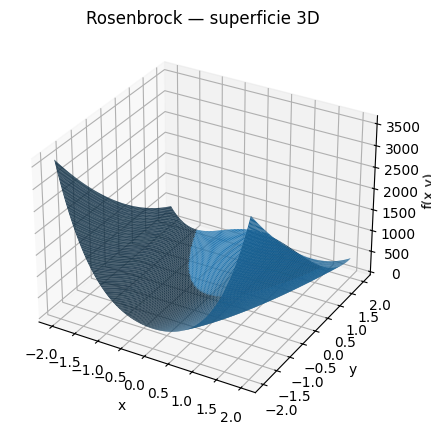

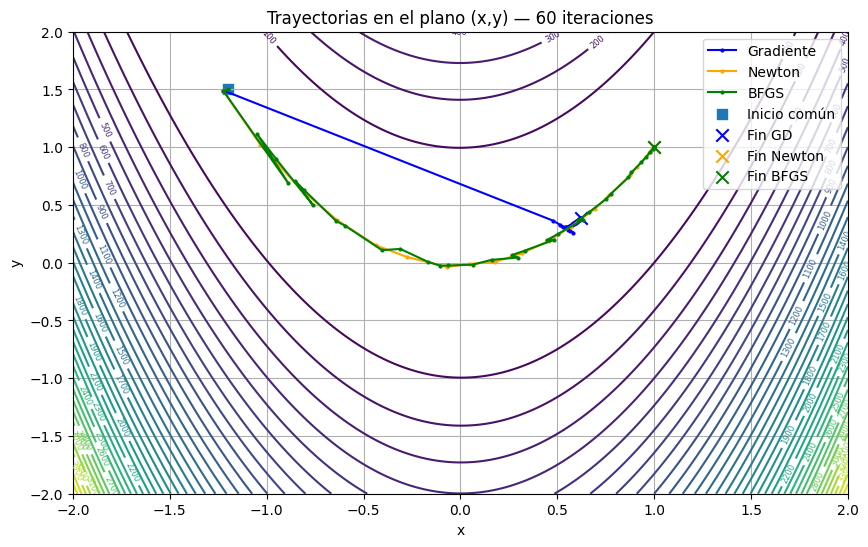

,Método,Iteraciones (K),f(x_K),|∇f(x_K)|,x_K
0,Gradiente,60,0.143921,1.197329,"[0.620966, 0.387193]"
1,Newton,60,0.000000,0.000000,"[1.0, 1.0]"
2,BFGS,60,0.000000,0.000000,"[1.0, 1.0]"


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve

# ---------- Definición de Rosenbrock ----------
def rosen_f(x):
    # x es vector (2,)
    return (1 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2

def rosen_g(x):
    # gradiente
    return np.array([
        2*(x[0]-1) - 400*x[0]*(x[1] - x[0]**2),
        200*(x[1] - x[0]**2)
    ], dtype=float)

def rosen_H(x):
    # Hessiano
    return np.array([
        [2 - 400*x[1] + 1200*x[0]**2, -400*x[0]],
        [-400*x[0], 200]
    ], dtype=float)

# ---------- Búsqueda en línea: Backtracking (Armijo) ----------
def armijo(f, g, x, p, alpha0=1.0, c=1e-4, tau=0.5, max_trials=30):
    alpha = alpha0
    fx = f(x)
    gx = g(x)
    for _ in range(max_trials):
        if f(x + alpha * p) <= fx + c * alpha * np.dot(gx, p):
            return alpha
        alpha *= tau
    return alpha  # lo que haya quedado (muy pequeño si no hubo éxito temprano)

# ---------- Métodos ----------
def gradient_descent_armijo(f, g, x0, K=60, alpha0=1.0):
    x = x0.copy().astype(float)
    xs, fs, gns = [x.copy()], [f(x)], [norm(g(x))]
    for k in range(K):
        grad = g(x)
        p = -grad
        # dirección de descenso garantizada
        alpha = armijo(f, g, x, p, alpha0=alpha0)
        x = x + alpha * p
        xs.append(x.copy())
        fs.append(f(x))
        gns.append(norm(g(x)))
    return np.array(xs), np.array(fs), np.array(gns)

def newton_armijo(f, g, H, x0, K=60, alpha0=1.0, reg=1e-8):
    x = x0.copy().astype(float)
    xs, fs, gns = [x.copy()], [f(x)], [norm(g(x))]
    for k in range(K):
        grad = g(x)
        Hx = H(x)
        # Regularización (si H no es bien condicionado)
        Hx = Hx + reg * np.eye(2)
        # Resolver H p = -g
        try:
            p = solve(Hx, -grad)
        except np.linalg.LinAlgError:
            p = -grad  # fallback
        # Asegurar dirección de descenso si fuera necesario
        if np.dot(grad, p) >= 0:
            p = -grad
        alpha = armijo(f, g, x, p, alpha0=alpha0)
        x = x + alpha * p
        xs.append(x.copy())
        fs.append(f(x))
        gns.append(norm(g(x)))
    return np.array(xs), np.array(fs), np.array(gns)

def bfgs_armijo(f, g, x0, K=60, alpha0=1.0, eps=1e-12):
    x = x0.copy().astype(float)
    n = len(x)
    Hinv = np.eye(n)  # aproximación a la inversa del Hessiano
    xs, fs, gns = [x.copy()], [f(x)], [norm(g(x))]
    for k in range(K):
        grad = g(x)
        p = - Hinv @ grad
        # Si por numerics no fuera descenso, usar -grad
        if np.dot(grad, p) >= 0:
            p = -grad
        alpha = armijo(f, g, x, p, alpha0=alpha0)
        x_new = x + alpha * p
        s = x_new - x
        y = g(x_new) - grad
        ys = np.dot(y, s)
        if ys > eps:
            rho = 1.0 / ys
            I = np.eye(n)
            V = I - rho * np.outer(s, y)
            Hinv = V @ Hinv @ V.T + rho * np.outer(s, s)
        x = x_new
        xs.append(x.copy())
        fs.append(f(x))
        gns.append(norm(g(x)))
    return np.array(xs), np.array(fs), np.array(gns)

# ---------- Visualización de Rosenbrock ----------
# Grid para superficies/contornos
xv = np.linspace(-2, 2, 500)
yv = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(xv, yv)
Z = (1 - X)**2 + 100.0*(Y - X**2)**2

# 3D surface
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0.2, antialiased=True)
ax.set_title("Rosenbrock — superficie 3D")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("f(x,y)")
plt.show()

# ---------- Experimentos comparativos ----------
x0 = np.array([-1.2, 1.5])  # punto inicial clásico
K = 60                      # misma cantidad de iteraciones para comparar

# Ejecutar métodos
xs_gd, fs_gd, gns_gd   = gradient_descent_armijo(rosen_f, rosen_g, x0, K=K, alpha0=1.0)
xs_new, fs_new, gns_new = newton_armijo(rosen_f, rosen_g, rosen_H, x0, K=K, alpha0=1.0)
xs_bfgs, fs_bfgs, gns_bfgs = bfgs_armijo(rosen_f, rosen_g, x0, K=K, alpha0=1.0)

# ---------- Gráfico: Trayectorias en el plano (x,y) ----------
plt.figure(figsize=(10,6))

# contornos de fondo
cs = plt.contour(X, Y, Z, levels=40)
plt.clabel(cs, inline=True, fontsize=6)

# trayectorias
plt.plot(xs_gd[:,0], xs_gd[:,1], marker='o', markersize=2, linestyle='-', label="Gradiente", color='blue')
plt.plot(xs_new[:,0], xs_new[:,1], marker='o', markersize=2, linestyle='-', label="Newton", color='orange')
plt.plot(xs_bfgs[:,0], xs_bfgs[:,1], marker='o', markersize=2, linestyle='-', label="BFGS", color='green')

# marcar inicio y fin de cada trayectoria
plt.scatter([x0[0]], [x0[1]], marker='s', s=60, label="Inicio común")
plt.scatter([xs_gd[-1,0]], [xs_gd[-1,1]], marker='x', s=80, label="Fin GD", color='blue')
plt.scatter([xs_new[-1,0]], [xs_new[-1,1]], marker='x', s=80, label="Fin Newton", color='orange')
plt.scatter([xs_bfgs[-1,0]], [xs_bfgs[-1,1]], marker='x', s=80, label="Fin BFGS", color='green')

plt.title(f"Trayectorias en el plano (x,y) — {K} iteraciones")
plt.xlabel("x"); plt.ylabel("y")
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# ---------- Resumen numérico (tabla) ----------
import pandas as pd
rows = []
methods = [
    ("Gradiente", xs_gd, fs_gd, gns_gd),
    ("Newton", xs_new, fs_new, gns_new),
    ("BFGS", xs_bfgs, fs_bfgs, gns_bfgs),
]
for name, xs, fs, gns in methods:
    rows.append({
        "Método": name,
        "Iteraciones (K)": K,
        "f(x_K)": float(fs[-1]),
        "|∇f(x_K)|": float(gns[-1]),
        "x_K": np.round(xs[-1], 6),
    })

df = pd.DataFrame(rows)
df
